In [1]:
from collections import defaultdict
import time

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from data import classification_dataset, train_test_split, kfolds
from layers import SeluConv3D, SeluDense
from callbacks import TimeEpoch
from plot import plot_slice, plot_volume_animation, plot_loss_history
from config import (
    LIDC_SMALL_NEG_TFRECORD,
    LIDC_BIG_NEG_TFRECORD,
    LIDC_SMALL_POS_TFRECORD,
    LIDC_BIG_POS_TFRECORD,
    SPIE_SMALL_NEG_TFRECORD,
    SPIE_BIG_NEG_TFRECORD,
    SPIE_SMALL_POS_TFRECORD,
    SPIE_BIG_POS_TFRECORD,
    SMALL_PATCH_SHAPE,
    BIG_PATCH_SHAPE,
)

%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
lidc_dataset, lidc_samples = classification_dataset(
    LIDC_SMALL_NEG_TFRECORD,
    LIDC_BIG_NEG_TFRECORD,
    LIDC_SMALL_POS_TFRECORD,
    LIDC_BIG_POS_TFRECORD,
    return_size=True,
)
print(f"{lidc_samples = }")
lidc_dataset

lidc_samples = 754


<ShuffleDataset shapes: (((None, None, None, None), (None, None, None, None)), (1,)), types: ((tf.float32, tf.float32), tf.int8)>

In [3]:
def build_3d_cnn():
    input_small = keras.Input(SMALL_PATCH_SHAPE, name="input_small")
    x_small = SeluConv3D(
        filters=32,
        kernel_size=3,
        name="small_selu_conv3d_1",
    )(input_small)
    x_small = keras.layers.MaxPool3D((1, 2, 2), name="small_maxpool_1")(x_small)
    x_small = SeluConv3D(
        filters=64,
        kernel_size=3,
        name="small_selu_conv3d_2",
    )(x_small)
    x_small = keras.layers.MaxPool3D((1, 2, 2), name="small_maxpool_2")(x_small)
    x_small = SeluConv3D(
        filters=128,
        kernel_size=3,
        name="small_selu_conv3d_3",
    )(x_small)
    x_small = keras.layers.MaxPool3D((1, 2, 2), name="small_maxpool_3")(x_small)
    x_small = SeluConv3D(
        filters=256,
        kernel_size=3,
        name="small_selu_conv3d_4",
    )(x_small)
    x_small = keras.layers.MaxPool3D((1, 2, 2), name="small_maxpool_4")(x_small)
    x_small = keras.layers.Flatten(name="flatten_small")(x_small)

    input_big = keras.Input(BIG_PATCH_SHAPE, name="input_big")
    x_big = keras.layers.MaxPool3D((2, 2, 2), name="big_maxpool_0")(input_big)
    x_big = SeluConv3D(
        filters=32,
        kernel_size=3,
        name="big_selu_conv3d_1",
    )(x_big)
    x_big = keras.layers.MaxPool3D((1, 2, 2), name="big_maxpool_1")(x_big)
    x_big = SeluConv3D(
        filters=64,
        kernel_size=3,
        name="big_selu_conv3d_2",
    )(x_big)
    x_big = keras.layers.MaxPool3D((1, 2, 2), name="big_maxpool_2")(x_big)
    x_big = SeluConv3D(
        filters=128,
        kernel_size=3,
        name="big_selu_conv3d_3",
    )(x_big)
    x_big = keras.layers.MaxPool3D((1, 2, 2), name="big_maxpool_3")(x_big)
    x_big = SeluConv3D(
        filters=256,
        kernel_size=3,
        name="big_selu_conv3d_4",
    )(x_big)
    x_big = keras.layers.MaxPool3D((1, 2, 2), name="big_maxpool_4")(x_big)
    x_big = keras.layers.Flatten(name="flatten_big")(x_big)

    x = keras.layers.concatenate([x_small, x_big], name="concatenate")
    x = keras.layers.Dense(1, activation="sigmoid", name="final_dense")(x)

    cnn_3d = keras.Model(inputs=[input_small, input_big], outputs=x, name="3dcnn")

    return cnn_3d

In [ ]:
learning_rate = 1e-5
val_perc = 0.1
patience = 30
batch_size = 16
metrics = [
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc"),
    keras.metrics.BinaryAccuracy(name="accuracy"),
]

In [ ]:
train_dataset, val_dataset = train_test_split(lidc_dataset, test_perc=val_perc)
val_dataset = val_dataset.batch(batch_size)
train_dataset = (
    train_dataset.cache()  # must be called before shuffle
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [ ]:
cnn = build_3d_cnn()
cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics,
)
time_callback = TimeEpoch()
history = cnn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1000,
    verbose=1,
    callbacks=[
        time_callback,
        keras.callbacks.ModelCheckpoint(
            "models/lidc-3d-cnn.h5",
            monitor="val_loss",
            save_best_only=True,
            verbose=1,
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=patience,
            restore_best_weights=True,
        ),
    ],
)

In [ ]:
cnn = keras.models.load_model("models/lidc-3d-cnn.h5")
cnn.evaluate(val_dataset, return_dict=True)

In [ ]:
plot_loss_history(history)
plt.savefig("lidc-loss.pdf")

In [ ]:
f"Mean time per epoch: {np.mean(time_callback.times):.2f}s"

In [4]:
spie_dataset, spie_samples = classification_dataset(
    SPIE_SMALL_NEG_TFRECORD,
    SPIE_BIG_NEG_TFRECORD,
    SPIE_SMALL_POS_TFRECORD,
    SPIE_BIG_POS_TFRECORD,
    return_size=True,
)
print(f"{spie_samples = }")
spie_dataset

spie_samples = 73


<ShuffleDataset shapes: (((None, None, None, None), (None, None, None, None)), (1,)), types: ((tf.float32, tf.float32), tf.int8)>

In [5]:
def build_pretrained_3d_cnn(freeze_conv_layers):
    pretrained_3d_cnn = keras.models.load_model("models/lidc-3d-cnn.h5")
    if freeze_conv_layers:
        for layer in pretrained_3d_cnn.layers:
            if "conv" in layer.name:
                layer.trainable = False
    return pretrained_3d_cnn

In [9]:
# k = spie_samples  # LOOCV
k = 10
val_perc = 0.1
learning_rate = 1e-5
batch_size = 8
patience = 20
num_epochs = 1000

In [10]:
lidc_metrics = [
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc", num_thresholds=1000),
    keras.metrics.BinaryAccuracy(name="accuracy"),
]
wo_pt_histories = []
wo_pt_metrics = [
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc", num_thresholds=1000),
    keras.metrics.BinaryAccuracy(name="accuracy"),
]
w_pt_histories = []
w_pt_metrics = [
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc", num_thresholds=1000),
    keras.metrics.BinaryAccuracy(name="accuracy"),
]
w_pt_conv_histories = []
w_pt_conv_metrics = [
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc", num_thresholds=1000),
    keras.metrics.BinaryAccuracy(name="accuracy"),
]
for fold_id, (train_dataset, test_dataset) in tqdm(
    enumerate(kfolds(k, spie_dataset, cardinality=spie_samples)), total=k
):
    test_dataset = test_dataset.batch(1)
    train_dataset, val_dataset = train_test_split(train_dataset, test_perc=val_perc)
    val_dataset = val_dataset.batch(batch_size)
    train_dataset = (
        train_dataset.cache()  # must be called before shuffle
        .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
        .batch(batch_size)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )

    cnn = keras.models.load_model("models/lidc-3d-cnn.h5")
    cnn.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
    )
    for test_x, test_y in test_dataset.as_numpy_iterator():
        pred_y = cnn(test_x, training=False)
        for metric in lidc_metrics:
            metric.update_state(test_y, pred_y)

    cnn = build_3d_cnn()
    cnn.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
    )
    history = cnn.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_epochs,
        verbose=0,
        callbacks=[
           keras.callbacks.EarlyStopping(
               monitor="val_loss",
               patience=patience,
               restore_best_weights=True,
           )
        ],
    )
    wo_pt_histories.append(history)
    for test_x, test_y in test_dataset.as_numpy_iterator():
        pred_y = cnn(test_x, training=False)
        for metric in wo_pt_metrics:
            metric.update_state(test_y, pred_y)

    cnn = build_pretrained_3d_cnn(False)
    cnn.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
    )
    history = cnn.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_epochs,
        verbose=0,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=patience,
                restore_best_weights=True,
            )
        ],
    )
    w_pt_histories.append(history)
    pred_y = cnn(test_x, training=False)
    for test_x, test_y in test_dataset.as_numpy_iterator():
        pred_y = cnn(test_x, training=False)
        for metric in w_pt_metrics:
            metric.update_state(test_y, pred_y)

    cnn = build_pretrained_3d_cnn(True)
    cnn.compile(
        optimizer=keras.optimizers.Adam(1e-5),
        loss=keras.losses.BinaryCrossentropy(),
    )
    history = cnn.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_epochs,
        verbose=0,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=patience,
                restore_best_weights=True,
            )
        ],
    )
    w_pt_conv_histories.append(history)
    for test_x, test_y in test_dataset.as_numpy_iterator():
        pred_y = cnn(test_x, training=False)
        for metric in w_pt_conv_metrics:
            metric.update_state(test_y, pred_y)

print(" average ".center(50, "="))
print("LIDC training only: ")
for metric in lidc_metrics:
    print(f"{metric.name}: {metric.result()}")
print("")
print("Without pretraining: ")
for metric in wo_pt_metrics:
    print(f"{metric.name}: {metric.result()}")
print("")

print("With pretraining (w/o conv freezing): ")
for metric in w_pt_metrics:
    print(f"{metric.name}: {metric.result()}")
print("")

print("With pretraining (w/ conv freezing): ")
for metric in w_pt_conv_metrics:
    print(f"{metric.name}: {metric.result()}")


==================== average =====================
LIDC training only: 
tp: 34.0
fp: 28.0
tn: 9.0
fn: 2.0
precision: 0.5483871102333069
recall: 0.9444444179534912
auc: 0.6779279112815857
accuracy: 0.5890411138534546

Without pretraining: 
tp: 23.0
fp: 24.0
tn: 13.0
fn: 13.0
precision: 0.4893617033958435
recall: 0.6388888955116272
auc: 0.5656906366348267
accuracy: 0.4931506812572479

With pretraining (w/o conv freezing): 
tp: 21.0
fp: 17.0
tn: 20.0
fn: 15.0
precision: 0.5526315569877625
recall: 0.5833333134651184
auc: 0.6212462782859802
accuracy: 0.5616438388824463

With pretraining (w/ conv freezing): 
tp: 28.0
fp: 21.0
tn: 16.0
fn: 8.0
precision: 0.5714285969734192
recall: 0.7777777910232544
auc: 0.6516517400741577
accuracy: 0.6027397513389587


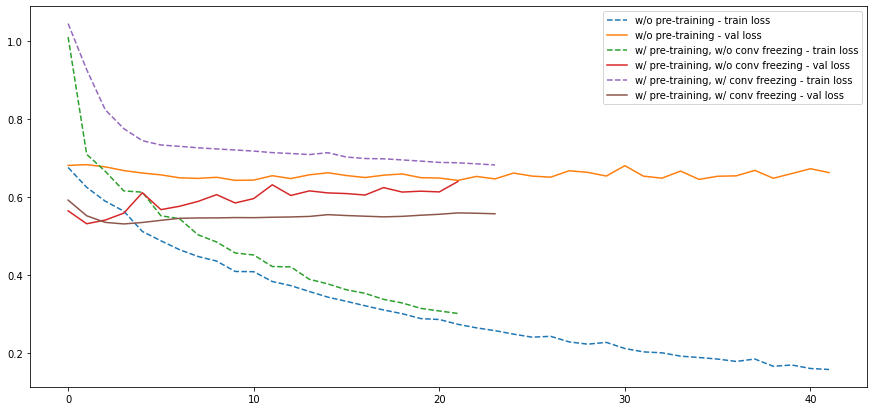

In [17]:
index = 0
plt.plot(
    wo_pt_histories[index].history["loss"], "--", label="w/o pre-training - train loss"
)
plt.plot(
    wo_pt_histories[index].history["val_loss"], label="w/o pre-training - val loss"
)
plt.plot(
    w_pt_histories[index].history["loss"],
    "--",
    label="w/ pre-training, w/o conv freezing - train loss",
)
plt.plot(
    w_pt_histories[index].history["val_loss"],
    label="w/ pre-training, w/o conv freezing - val loss",
)
plt.plot(
    w_pt_conv_histories[index].history["loss"],
    "--",
    label="w/ pre-training, w/ conv freezing - train loss",
)
plt.plot(
    w_pt_conv_histories[index].history["val_loss"],
    label="w/ pre-training, w/ conv freezing - val loss",
)
plt.legend()
# plot_loss_history(w_pt_conv_histories[0])

In [7]:
k = 10
val_perc = 0.1
learning_rate = 1e-5
batch_size = 8
num_epochs = 1000
metrics = [
    #keras.metrics.TruePositives(name="tp"),
    #keras.metrics.FalsePositives(name="fp"),
    #keras.metrics.TrueNegatives(name="tn"),
    #keras.metrics.FalseNegatives(name="fn"),
    #keras.metrics.Precision(name="precision"),
    #keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc"),
    keras.metrics.BinaryAccuracy(name="accuracy"),
]

In [8]:
lidc_mean_metrics = {
    f"{metric.name}": keras.metrics.Mean(name=f"mean_{metric.name}")
    for metric in metrics
}
wo_pt_histories = []
wo_pt_mean_metrics = {
    f"{metric.name}": keras.metrics.Mean(name=f"mean_{metric.name}")
    for metric in metrics
}
w_pt_histories = []
w_pt_mean_metrics = {
    f"{metric.name}": keras.metrics.Mean(name=f"mean_{metric.name}")
    for metric in metrics
}
w_pt_conv_histories = []
w_pt_conv_mean_metrics = {
    f"{metric.name}": keras.metrics.Mean(name=f"mean_{metric.name}")
    for metric in metrics
}
for fold_id, (train_dataset, test_dataset) in tqdm(
    enumerate(kfolds(k, spie_dataset, cardinality=spie_samples)), total=k
):
    print(f" {fold_id = } ".center(50, "="))

    test_dataset = test_dataset.batch(batch_size)
    train_dataset, val_dataset = train_test_split(train_dataset, test_perc=val_perc)
    val_dataset = val_dataset.batch(batch_size)
    train_dataset = (
        train_dataset.cache()  # must be called before shuffle
        .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
        .batch(batch_size)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )
    print(f"Train size: {sum(1 for _ in train_dataset.unbatch())}")
    print(f"Validation size: {sum(1 for _ in val_dataset.unbatch())}")
    print(f"Test size: {sum(1 for _ in test_dataset.unbatch())}")
    print()

    cnn = keras.models.load_model("models/lidc-3d-cnn.h5")
    cnn.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics,
    )
    test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=0)
    print("LIDC training only: ")
    for metric_name, metric_value in test_metrics.items():
        print(f"{metric_name}: {metric_value}")
        if metric_name in lidc_mean_metrics:
            lidc_mean_metrics[metric_name].update_state(metric_value)
    print("")

    cnn = build_3d_cnn()
    cnn.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics,
    )
    history = cnn.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=1000,
        verbose=0,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=20,
                restore_best_weights=True,
            )
        ],
    )
    wo_pt_histories.append(history)
    test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=0)
    print("Without pretraining: ")
    for metric_name, metric_value in test_metrics.items():
        print(f"{metric_name}: {metric_value}")
        if metric_name in wo_pt_mean_metrics:
            wo_pt_mean_metrics[metric_name].update_state(metric_value)
    print("")

    cnn = build_pretrained_3d_cnn(False)
    cnn.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics,
    )
    history = cnn.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=1000,
        verbose=0,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=20,
                restore_best_weights=True,
            )
        ],
    )
    w_pt_histories.append(history)
    test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=0)
    print("With pretraining (w/o conv freezing): ")
    for metric_name, metric_value in test_metrics.items():
        print(f"{metric_name}: {metric_value}")
        if metric_name in w_pt_mean_metrics:
            w_pt_mean_metrics[metric_name].update_state(metric_value)
    print("")

    cnn = build_pretrained_3d_cnn(True)
    cnn.compile(
        optimizer=keras.optimizers.Adam(1e-5),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics,
    )
    history = cnn.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=1000,
        verbose=0,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=20,
                restore_best_weights=True,
            )
        ],
    )
    w_pt_conv_histories.append(history)
    test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=0)
    print("With pretraining (w/ conv freezing): ")
    for metric_name, metric_value in test_metrics.items():
        print(f"{metric_name}: {metric_value}")
        if metric_name in w_pt_conv_mean_metrics:
            w_pt_conv_mean_metrics[metric_name].update_state(metric_value)

print(" average ".center(50, "="))
print("LIDC training only: ")
for metric_name, metric_value in lidc_mean_metrics.items():
    print(f"{metric_name}: {metric_value.result()}")
print("")
print("Without pretraining: ")
for metric_name, metric_value in wo_pt_mean_metrics.items():
    print(f"{metric_name}: {metric_value.result()}")
print("")

print("With pretraining (w/o conv freezing): ")
for metric_name, metric_value in w_pt_mean_metrics.items():
    print(f"{metric_name}: {metric_value.result()}")
print("")

print("With pretraining (w/ conv freezing): ")
for metric_name, metric_value in w_pt_conv_mean_metrics.items():
    print(f"{metric_name}: {metric_value.result()}")

================== fold_id = 0 ===================
Train size: 60
Validation size: 6
Test size: 7

LIDC training only: 
loss: 1.2101391553878784
auc: 0.5999999642372131
accuracy: 0.4285714328289032

Without pretraining: 
loss: 0.6310005187988281
auc: 0.5
accuracy: 0.7142857313156128

With pretraining (w/o conv freezing): 
loss: 0.6711919903755188
auc: 0.6000000238418579
accuracy: 0.7142857313156128

With pretraining (w/ conv freezing): 
loss: 0.7306119203567505
auc: 0.7000000476837158
accuracy: 0.5714285969734192
================== fold_id = 1 ===================
Train size: 60
Validation size: 6
Test size: 7

LIDC training only: 
loss: 0.8613850474357605
auc: 0.7448979616165161
accuracy: 0.7142857313156128

Without pretraining: 
loss: 0.9499872326850891
auc: 0.3500000238418579
accuracy: 0.4285714328289032

With pretraining (w/o conv freezing): 
loss: 1.1047179698944092
auc: 0.5
accuracy: 0.4285714328289032

With pretraining (w/ conv freezing): 
loss: 0.9979480504989624
auc: 0.60000002

KeyboardInterrupt: 

In [ ]:
histories = w_pt_conv_histories
_, ax = plt.subplots(nrows=2, ncols=2)
plot_loss_history(histories[0], ax[0][0])
# ax[0][0].set_title("Training=[k_2, k_3, k_4]; Test=[k_1]")
plot_loss_history(histories[1], ax[0][1])
# ax[0][1].set_title("Training=[k_1, k_3, k_4]; Test=[k_2]")
plot_loss_history(histories[2], ax[1][0])
# ax[0][1].set_title("Training=[k_1, k_2, k_4]; Test=[k_3]")
plot_loss_history(histories[3], ax[1][1])
# ax[0][1].set_title("Training=[k_1, k_2, k_3]; Test=[k_4]");
plt.savefig("w-pt-conv-losses.pdf")